# 프로젝트: 인물 모드 문제점 찾기

In [14]:
import os
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

from importlib.metadata import version

# OpenCV 및 PixelLib 버전 확인
print(cv2.__version__)
print(version('pixellib'))

# Pascal VOC 데이터셋의 라벨 리스트
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

# 컬러맵 생성
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

print(colormap[:20])  # 생성된 20개의 컬러맵 출력

# 모델 로드
model_dir = os.getenv('HOME') + '/aiffel/human_segmentation_1/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)  # PASCAL VOC 사전 학습 모델 로드


4.5.3
0.7.1
[[  0   0   0]
 [128   0   0]
 [  0 128   0]
 [128 128   0]
 [  0   0 128]
 [128   0 128]
 [  0 128 128]
 [128 128 128]
 [ 64   0   0]
 [192   0   0]
 [ 64 128   0]
 [192 128   0]
 [ 64   0 128]
 [192   0 128]
 [ 64 128 128]
 [192 128 128]
 [  0  64   0]
 [128  64   0]
 [  0 192   0]
 [128 192   0]]


In [15]:
class_info = []

# 함수: 세그멘테이션 및 배경 블러 적용
def segment_and_blur_background(img_path, seg_color=(128, 128, 192)):
    """
    이미지 경로를 받아, 특정 객체의 세그멘테이션을 수행하고 배경을 블러 처리하여 반환
    :param img_path: 처리할 이미지 경로
    :param seg_color: 세그멘테이션 마스크 색상 (기본: 사람)
    :return: 원본 이미지, 세그멘테이션 후 배경 블러링 이미지
    """
    img_orig = cv2.imread(img_path)  # 이미지 로드

    # 모델을 사용하여 세그멘테이션 수행
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
#     for class_id in segvalues['class_ids']:
#         print(class_id,LABEL_NAMES[class_id], colormap[class_id])
    global class_info
    class_info.clear()

    for class_id in segvalues['class_ids']:
        class_name = LABEL_NAMES[class_id]
        class_color = colormap[class_id]
        class_info.append((class_id, class_name, class_color))

    # 세그멘테이션 맵 생성
    seg_map = np.all(output == seg_color, axis=-1)

    # 원본 이미지 복사
    img_show = img_orig.copy()

    # 마스크 생성 및 적용
    img_mask = seg_map.astype(np.uint8) * 255
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

    # 배경 블러 처리
    img_orig_blur = cv2.blur(img_orig, (23, 23))  # 블러 처리
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 마스크를 컬러로 변환
    img_bg_mask = cv2.bitwise_not(img_mask_color)  # 반전 마스크 생성
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  # 블러 적용된 배경 생성

    # 배경과 객체를 합성
    img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)

    return img_orig, img_concat

## Step 1. 인물모드 직접 해 보기

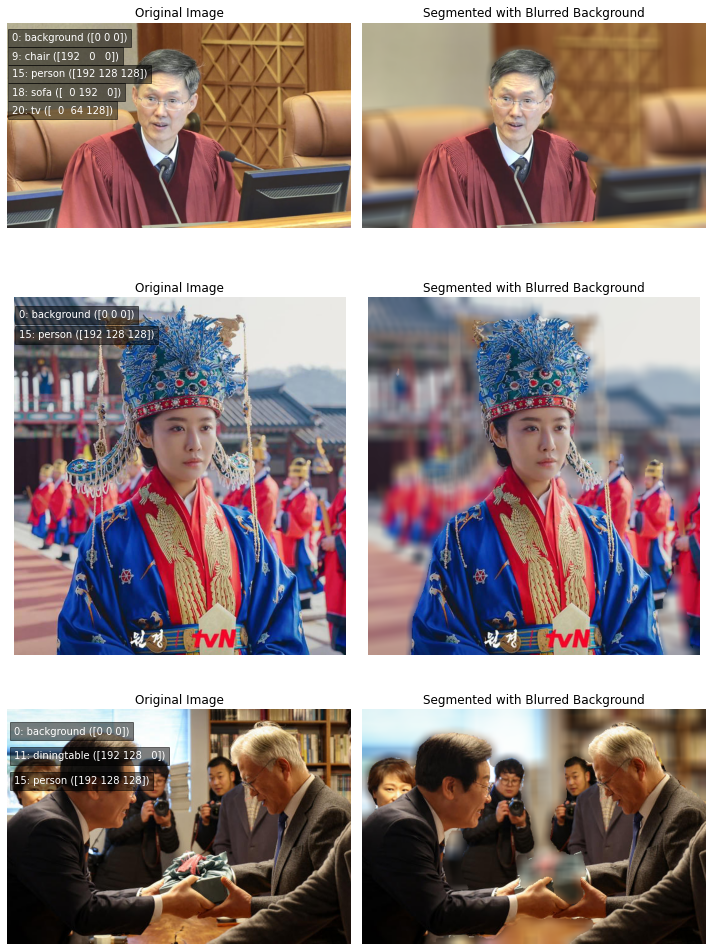

In [18]:
# 여러 인물 이미지 처리
image_paths = [
    os.getenv('HOME') + '/aiffel/human_segmentation_1/images/image1.jpg',
    os.getenv('HOME') + '/aiffel/human_segmentation_1/images/image2.jpg',
    os.getenv('HOME') + '/aiffel/human_segmentation_1/images/image3.jpg'
]

# 결과 시각화
fig, axes = plt.subplots(len(image_paths), 2, figsize=(10, len(image_paths) * 5))

for i, img_path in enumerate(image_paths):
    original, segmented = segment_and_blur_background(img_path)

    axes[i, 0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")
    
    # 원본 이미지에 클래스 정보 표시
    for j, (class_id, class_name, class_color) in enumerate(class_info):
        axes[i, 0].text(10, 40 + j * 40, f"{class_id}: {class_name} ({class_color})", 
                         fontsize=10, color='white', bbox=dict(facecolor='black', alpha=0.5))

    axes[i, 1].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("Segmented with Blurred Background")
    axes[i, 1].axis("off")
    
        
plt.tight_layout()
plt.show()
        

## Step 2. 사진에서 문제점 찾기


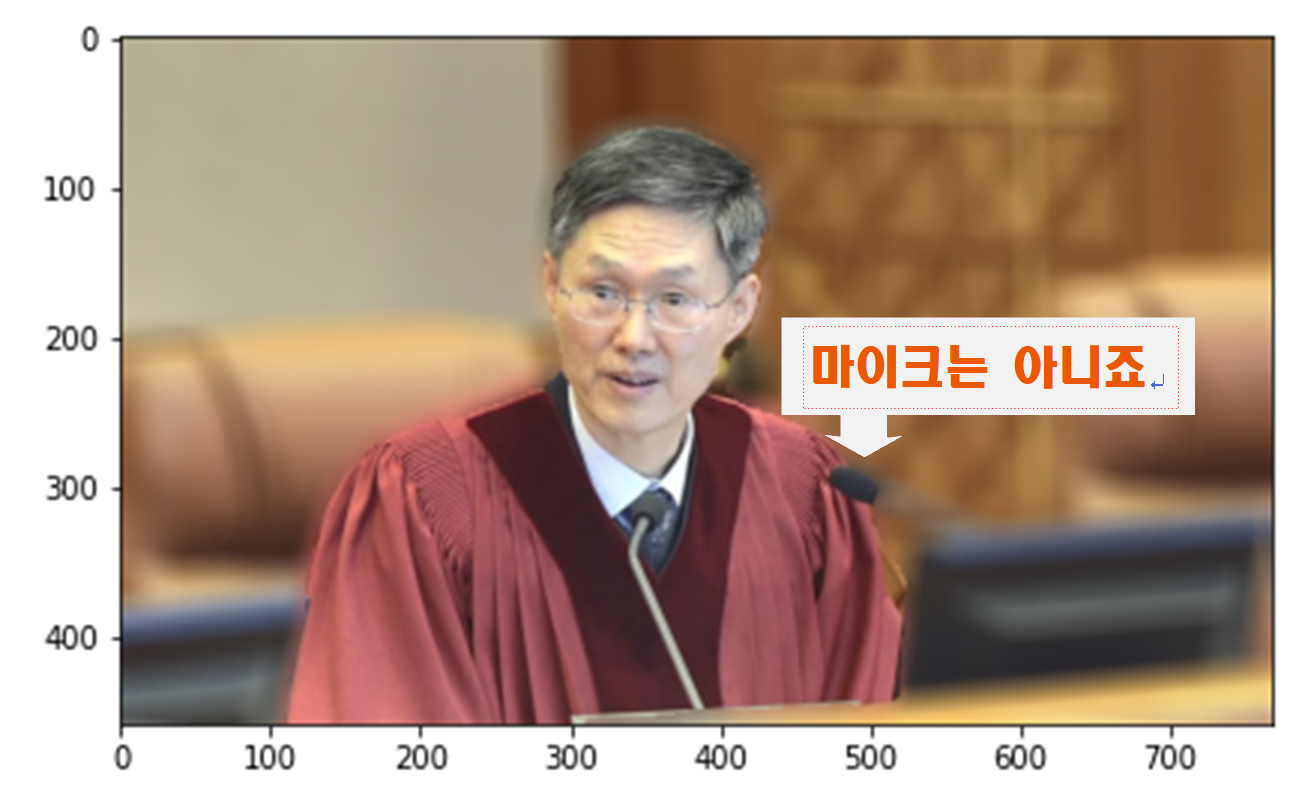

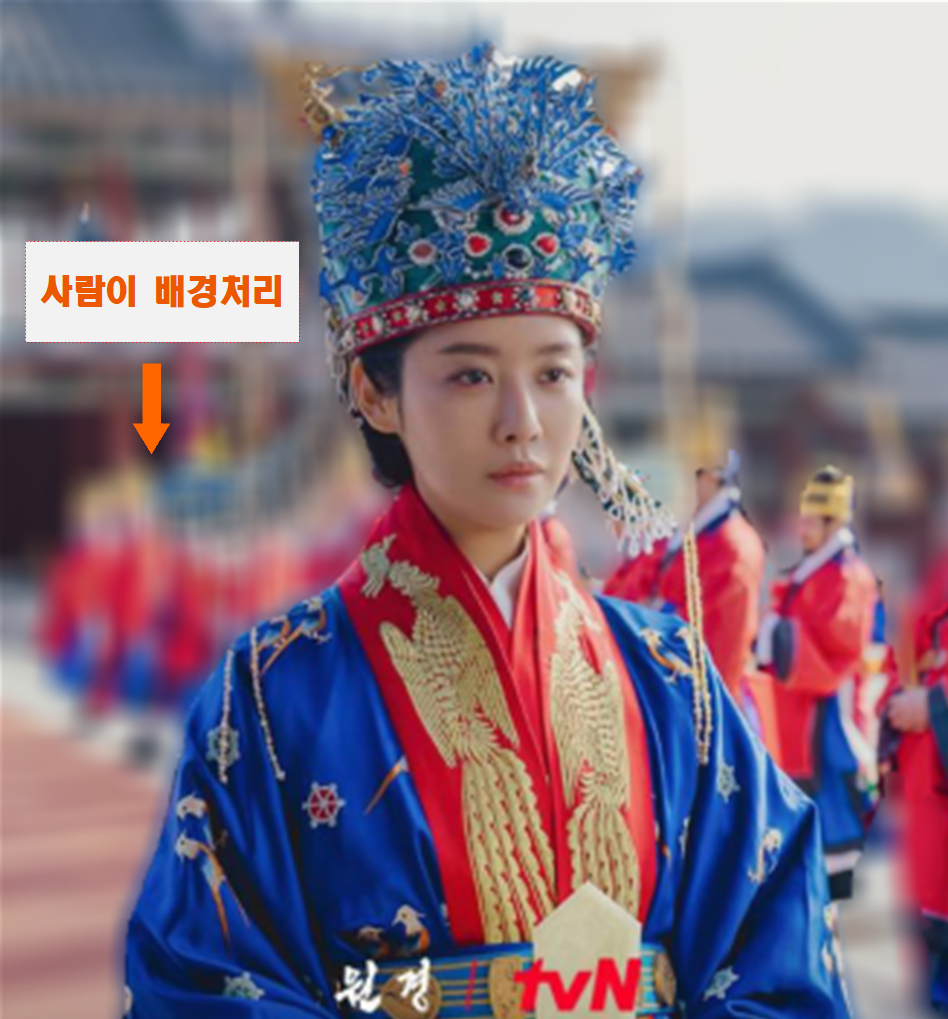

# Step 3. 해결 방법을 제안해 보기

### 1. 문제 개요

현재 Semantic Segmentation 기반 인물 모드는 피사체와 배경을 분리하는 데 있어 완벽하지 않은 Mask를 생성하는 한계를 가지고 있다. 이는 다음과 같은 문제를 유발한다.

 - Edge Artifacts: 인물의 경계 부분에서 블러(Blur) 처리 오류 발생
 - Depth Inconsistency: 배경이 인위적으로 구분되어 깊이 정보가 부자연스러움
 - Hair & Transparency Issues: 머리카락, 악세사리, 반투명한 요소(안경 등)에서 오류 발생
 
이를 해결하기 위해 하드웨어 기반 3D Depth Sensing과 소프트웨어 기반 Monocular Depth Estimation을 결합한 Hybrid Depth Estimation & Refinement 기법을 제안합니다.



### 2. 해결책: Hybrid Depth Estimation & Refinement


#### A. Multi-Source Depth Estimation

기존 Semantic Segmentation 기반의 마스크 생성 방식에 3D Depth Sensing 기술을 추가로 결합하여 더욱 정교한 깊이 정보를 추출합니다. 이를 위해 다음 세 가지 접근 방식을 조합합니다.

1. Semantic Segmentation (기존 방식)

 - DeepLab 모델을 활용하여 피사체의 영역을 분리
 - 하지만 경계 부분의 정확도가 부족하여 추가 보정 필요
 
 
2. 3D Depth Sensing (하드웨어 보강)

 - ToF(Time-of-Flight) 센서 또는 Stereo Vision을 활용하여 깊이 정보를 측정
 - 특히 ToF 센서는 빛의 반사 속도를 기반으로 거리 정보를 얻기 때문에 정밀한 Depth Map 생성 가능
 - Stereo Vision은 듀얼 카메라를 이용하여 깊이 차이를 계산
 
 
3. Monocular Depth Estimation (소프트웨어 보강)

 - Struct2Depth 같은 Self-Supervised Depth Estimation 모델을 활용
 - 단일 이미지에서 피사체와 배경 간의 깊이 차이를 학습하여 추정
 - Semantic Segmentation에서 발생하는 Edge Artifacts를 보완하는 역할 수행
 
 
 
#### B. Depth Map Refinement & Adaptive Blurring

위에서 얻어진 Multi-Source Depth 데이터를 기반으로, 인물모드 효과를 보다 자연스럽게 구현하기 위해 아래의 Adaptive Blurring을 적용합니다.

1. Depth Fusion & Confidence Weighting

 - Semantic Segmentation, 3D Depth Sensing, Monocular Depth Estimation의 결과물을 Confidence Weighting 방식으로 통합
 - 신뢰도가 높은 Depth 정보를 우선적으로 사용하여 Depth Map을 정제


2. Edge-Aware Depth Refinement

 - Guided Filter 또는 Bilateral Filtering을 활용하여 경계 부분의 깊이 정보를 보정
 - 이 과정에서 머리카락, 반투명한 오브젝트의 표현이 더욱 정교해짐


3. Bokeh Simulation with Adaptive Gaussian Blur

 - 최종 Depth Map을 기반으로 Adaptive Gaussian Blur 적용
 - 기존 단순 블러링 방식이 아닌, Depth 값에 따라 블러 강도를 비례적으로 조절
 - 실제 광학적 피사계심도 효과를 시뮬레이션하여 더욱 자연스러운 보케 효과 구현
 
 

### 3. 솔루션 동작 방식 Flow Chart

```
[Input Image]
      ↓
[Semantic Segmentation (DeepLab)]
      ↓
[Multi-Source Depth Estimation]
      ├── (1) 3D Depth Sensing (ToF/Stereo Vision)
      ├── (2) Monocular Depth Estimation (Struct2Depth)
      ├── (3) Fusion & Confidence Weighting
      ↓
[Refinement: Edge-Aware Filtering]
      ↓
[Adaptive Gaussian Blur Based on Depth Map]
      ↓
[Final Portrait Mode Output]
```


### 4. 기대 효과

 - 정확도 향상: 단순 Semantic Segmentation 기반 방식보다 더욱 정밀한 Depth Map을 생성
 - 자연스러운 보케 효과: Depth 기반 Adaptive Gaussian Blur 적용으로 광학적인 느낌 강화
 - 경계 오류 감소: Edge-Aware Refinement 기법을 사용하여 머리카락 및 반투명 요소 보정
 - 하드웨어 & 소프트웨어 융합: ToF 센서, Stereo Vision, AI 기반 Depth Estimation의 조합으로 최적화된 성능 제공
 

### 5. 결론

 - 기존 Semantic Segmentation 방식의 한계를 극복하기 위해 
 - 3D Depth Sensing + AI 기반 Monocular Depth Estimation을 결합한 Hybrid Approach를 도입
 - 이를 통해 더욱 정밀한 피사체 분리와 자연스러운 아웃포커싱 효과를 제공
